# Compute UMAPs outside of model training pipeline

Extract the key UMAP functions from the OOP framework so that I can compute for any data.

In [1]:
import os
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import polars as pl
import umap.umap_ as umap
from cytoself.analysis.analysis_opencell import AnalysisOpenCell
from cytoself.datamanager.opencell import DataManagerOpenCell
from cytoself.trainer.cytoselflite_trainer import CytoselfFullTrainer
from cytoself.trainer.utils.plot_history import plot_history_cytoself
from cytoself.analysis.utils.cluster_score import calculate_cluster_centrosize

/home/shenrunx/software/anaconda3/envs/cytoself/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Loading trained model

In [2]:
datapath = '../inputs/1_model_input/2024_05_B78-1314-1516'
outputpath = "../outputs/trained_models/varchamp_050725"
model_nm = "model_43.pt"
data_ch = ['pro', 'nuc']
device="cuda:0"
model_path = f"{outputpath}/{model_nm}"

In [ ]:
# datamanager = DataManagerOpenCell(datapath, data_ch, fov_col=None)
# datamanager.const_dataloader(batch_size=32, label_name_position=1)

# model_args = {
#     "input_shape": (2, 100, 100),
#     "emb_shapes": ((25, 25), (4, 4)),
#     "output_shape": (2, 100, 100),
#     "fc_output_idx": [2],
#     "vq_args": {"num_embeddings": 512, "embedding_dim": 64},
#     "num_class": len(datamanager.unique_labels),
#     "fc_input_type": "vqvec",
# }
# train_args = {
#     "lr": 0.0004,
#     "max_epoch": 100,
#     "reducelr_patience": 4,
#     "reducelr_increment": 0.1,
#     "earlystop_patience": 12,
# }

# trainer = CytoselfFullTrainer(train_args, homepath=outputpath, model_args=model_args)
# trainer.load_model(model_path)

# # infer embeddings
# test_embeddings = trainer.infer_embeddings(datamanager.DataLoader)

# if isinstance(test_embeddings, tuple) and len(test_embeddings) > 1:
#     test_embeddings = test_embeddings[0]

# savepath_embeddings = trainer.savepath_dict["embeddings"]
# np.save(join(savepath_embeddings, 'embeddings_testdata.npy'), test_embeddings)

# # infer embeddings for training data 
# train_embeddings = trainer.infer_embeddings(datamanager.train_loader)
# if isinstance(train_embeddings, tuple) and len(train_embeddings) > 1:
#     train_embeddings = train_embeddings[0]

# savepath_embeddings = trainer.savepath_dict["embeddings"]
# np.save(join(savepath_embeddings, 'embeddings_traindata.npy'), train_embeddings)

# # infer embeddings for training data 
# valid_embeddings = trainer.infer_embeddings(datamanager.val_loader)
# if isinstance(valid_embeddings, tuple) and len(valid_embeddings) > 1:
#     valid_embeddings = valid_embeddings[0]

# savepath_embeddings = trainer.savepath_dict["embeddings"]
# np.save(join(savepath_embeddings, 'embeddings_valdata.npy'), valid_embeddings)


# # save labels by data
# train_labels = datamanager.train_loader.dataset.label
# np.save(join(savepath_embeddings, 'labels_traindata.npy'), train_labels)

# val_labels = datamanager.val_loader.dataset.label
# np.save(join(savepath_embeddings, 'labels_valdata.npy'), val_labels)

# test_labels = datamanager.test_loader.dataset.label
# np.save(join(savepath_embeddings, 'labels_testdata.npy'), test_labels)

# 2. Plot UMAPs

In [3]:
import seaborn as sns
from adjustText import adjust_text

In [4]:
umap_path = "../outputs/analysis/umap_data"

trainer_embeddings = np.load(join(f"{outputpath}/embeddings", 'embeddings_traindata.npy'))
val_embeddings = np.load(join(f"{outputpath}/embeddings", 'embeddings_valdata.npy'))
test_embeddings = np.load(join(f"{outputpath}/embeddings", 'embeddings_testdata.npy'))

train_labels = np.load(join(f"{outputpath}/embeddings", 'labels_traindata.npy'), allow_pickle=True)
val_labels = np.load(join(f"{outputpath}/embeddings", 'labels_valdata.npy'), allow_pickle=True)
test_labels = np.load(join(f"{outputpath}/embeddings", 'labels_testdata.npy'), allow_pickle=True)

In [5]:
umap_test_df = pl.read_parquet(join(umap_path, "umap_comps_testdata.parquet"))
umap_test_df = umap_test_df.with_columns(
    pl.col("Metadata_CellID").str.extract(r"(B\d+)A", 1).alias("batch"),
    pl.col("Metadata_CellID").str.slice(23,3).alias("well_position"),
    pl.col("Metadata_Protein").str.split(by="-").list.get(0).alias("Gene"),
    (pl.when(pl.col("Metadata_Protein").str.contains("-"))
    .then(pl.lit("Allele"))
    .otherwise(pl.lit("Reference"))).alias("Allele_type")
)
umap_test_df.head()

Metadata_Protein,Metadata_CellID,Comp1,Comp2,batch,well_position,Gene,Allele_type
str,str,f32,f32,str,str,str,str
"""AP2S1""","""2025-03-17_B15A1A2_P1T2_A01_9_…",16.701048,4.051145,"""B15""","""_A0""","""AP2S1""","""Reference"""
"""CCM2-Thr296Ala""","""2025_01_28_B14A7A8P2_T2_D17_79…",10.497385,-5.428692,"""B14""","""_D1""","""CCM2""","""Allele"""
"""AP2S1""","""2025-03-17_B15A1A2_P1T1_A01_6_…",16.545809,3.918845,"""B15""","""_A0""","""AP2S1""","""Reference"""
"""RET-Val262Ala""","""2025_01_27_B13A7A8P2_T3_K15_22…",-2.007865,-1.652548,"""B13""","""_K1""","""RET""","""Allele"""
"""RHEB""","""2025-03-18_B16A1A2_P1T2_J15_20…",17.409161,2.800611,"""B16""","""_J1""","""RHEB""","""Reference"""


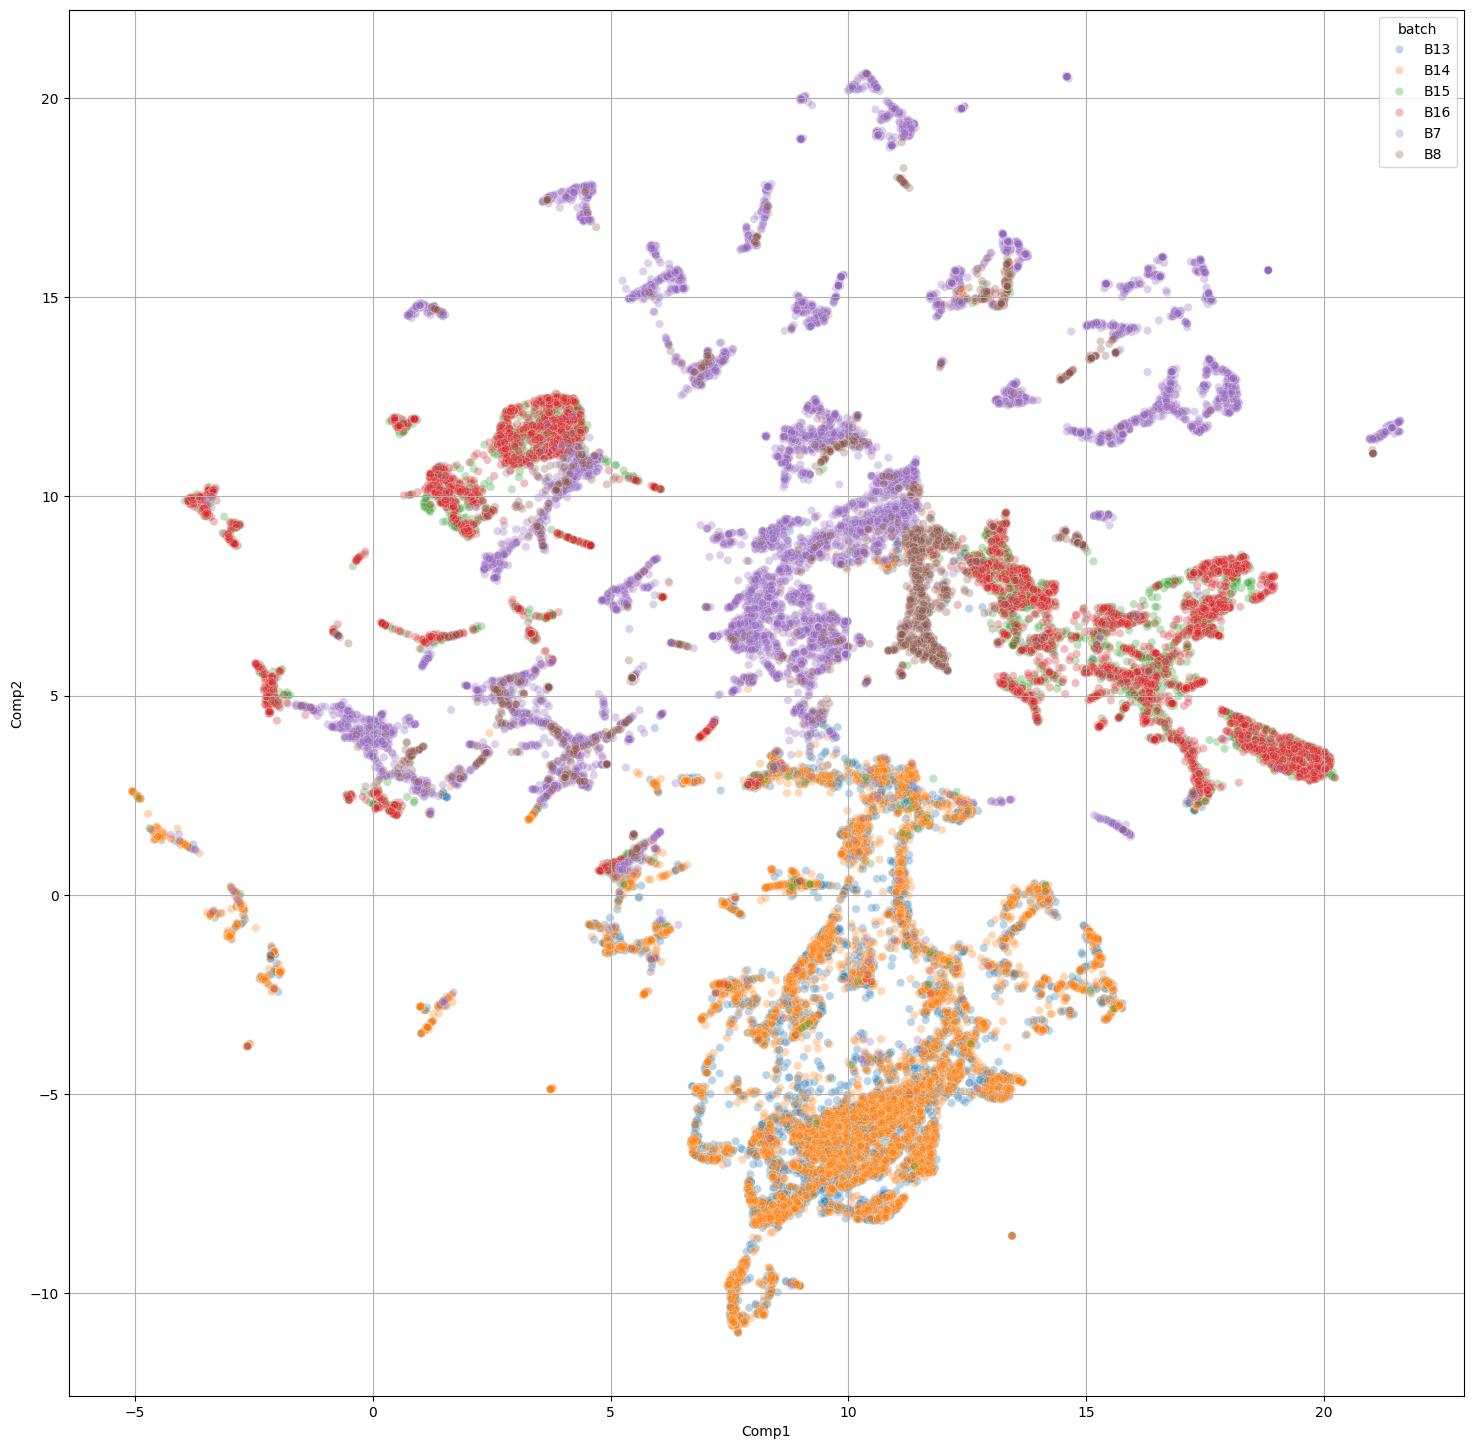

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
sns.scatterplot(umap_test_df.sample(fraction=.2, shuffle=True).sort(by="batch"), 
x="Comp1", y="Comp2", hue="batch", alpha=.3, ax=ax)
ax.grid(True)

2025-05-10 14:34:09,391 - WARNING - Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


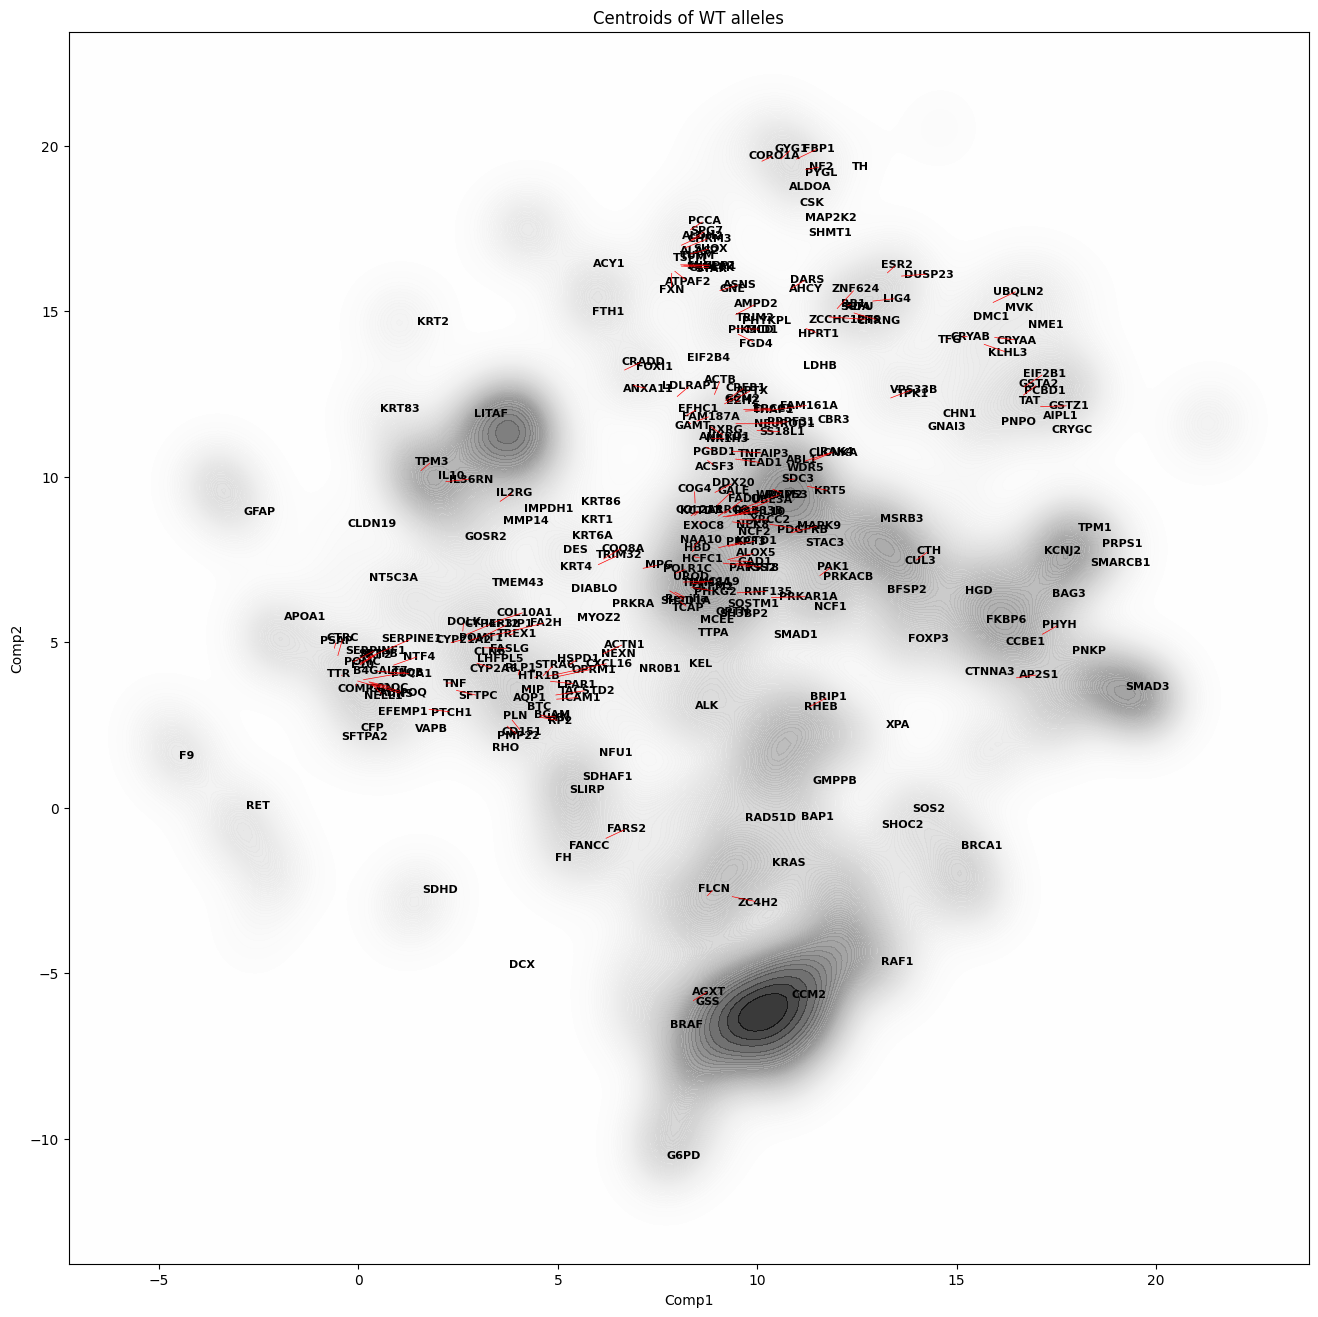

In [36]:
# Compute centroid of each WT
wt_centroid = umap_test_df.filter(~pl.col("Metadata_Protein").str.contains("-")).group_by("Metadata_Protein").agg([
    pl.col("Comp1").median().alias("Comp1"),
    pl.col("Comp2").median().alias("Comp2"),
])

plt.figure(figsize=(16, 16))
sns.kdeplot(data=umap_test_df.to_pandas(), x="Comp1", y="Comp2", fill=True, cmap="Greys", alpha=0.8, thresh=0, levels=100)

# Overlay the text labels
texts = []
for i, row in wt_centroid.to_pandas().iterrows():
    texts.append(plt.text(row["Comp1"], row["Comp2"], row["Metadata_Protein"], 
                          fontsize=8, fontweight='bold', color='black'))

# Adjust text to avoid overlaps
adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5))
plt.title("Centroids of WT alleles")
plt.savefig(f"{outputpath}/analysis/umap_figures/umap_wt_centroid_density.svg", format='svg')

In [29]:
def get_custom_colormap(num_colors, first_color='#D3D3D3'):
    # Generate a colormap with the specified number of colors
    # cmap = plt.get_cmap('tab10', num_colors)
    # Generate a color palette with 25 distinct colors using the 'cubehelix' system
    palette = sns.color_palette("husl", num_colors)
    colors = palette # [first_color]
    # colors += [c for c in palette if c != first_color]
    # Replace the first color with light grey
    return colors

In [ ]:
def plot_gene_umap(umap_df, gene):
    fig, ax = plt.subplots(1, 1, figsize=(18, 18))
    ax.grid(True)

    umap_df = umap_df.with_columns(
        pl.when(pl.col("Metadata_Protein").str.contains(gene))
        .then(pl.col("Metadata_Protein"))
        .otherwise(pl.lit("000")).alias(f"{gene}_Variant")
    ).sort(f"{gene}_Variant")
    
    sns.scatterplot(umap_df.filter(pl.col(f"{gene}_Variant") == "000"), x="Comp1", y="Comp2", color="grey", alpha=.1, ax=ax)
    colors = get_custom_colormap(len(umap_df.select(f"{gene}_Variant").unique().to_numpy()))
    sns.scatterplot(umap_df.filter(pl.col(f"{gene}_Variant") != "000"), x="Comp1", y="Comp2", hue=f"{gene}_Variant", style="batch", palette=colors, ax=ax, s=70, alpha=0.7)

/tmp/ipykernel_948654/2881440059.py:13: UserWarning: The palette list has more values (27) than needed (26), which may not be intended.
  sns.scatterplot(umap_df.filter(pl.col(f"{gene}_Variant") != "000"), x="Comp1", y="Comp2", hue=f"{gene}_Variant", style="batch", palette=colors, ax=ax, s=70, alpha=0.7)


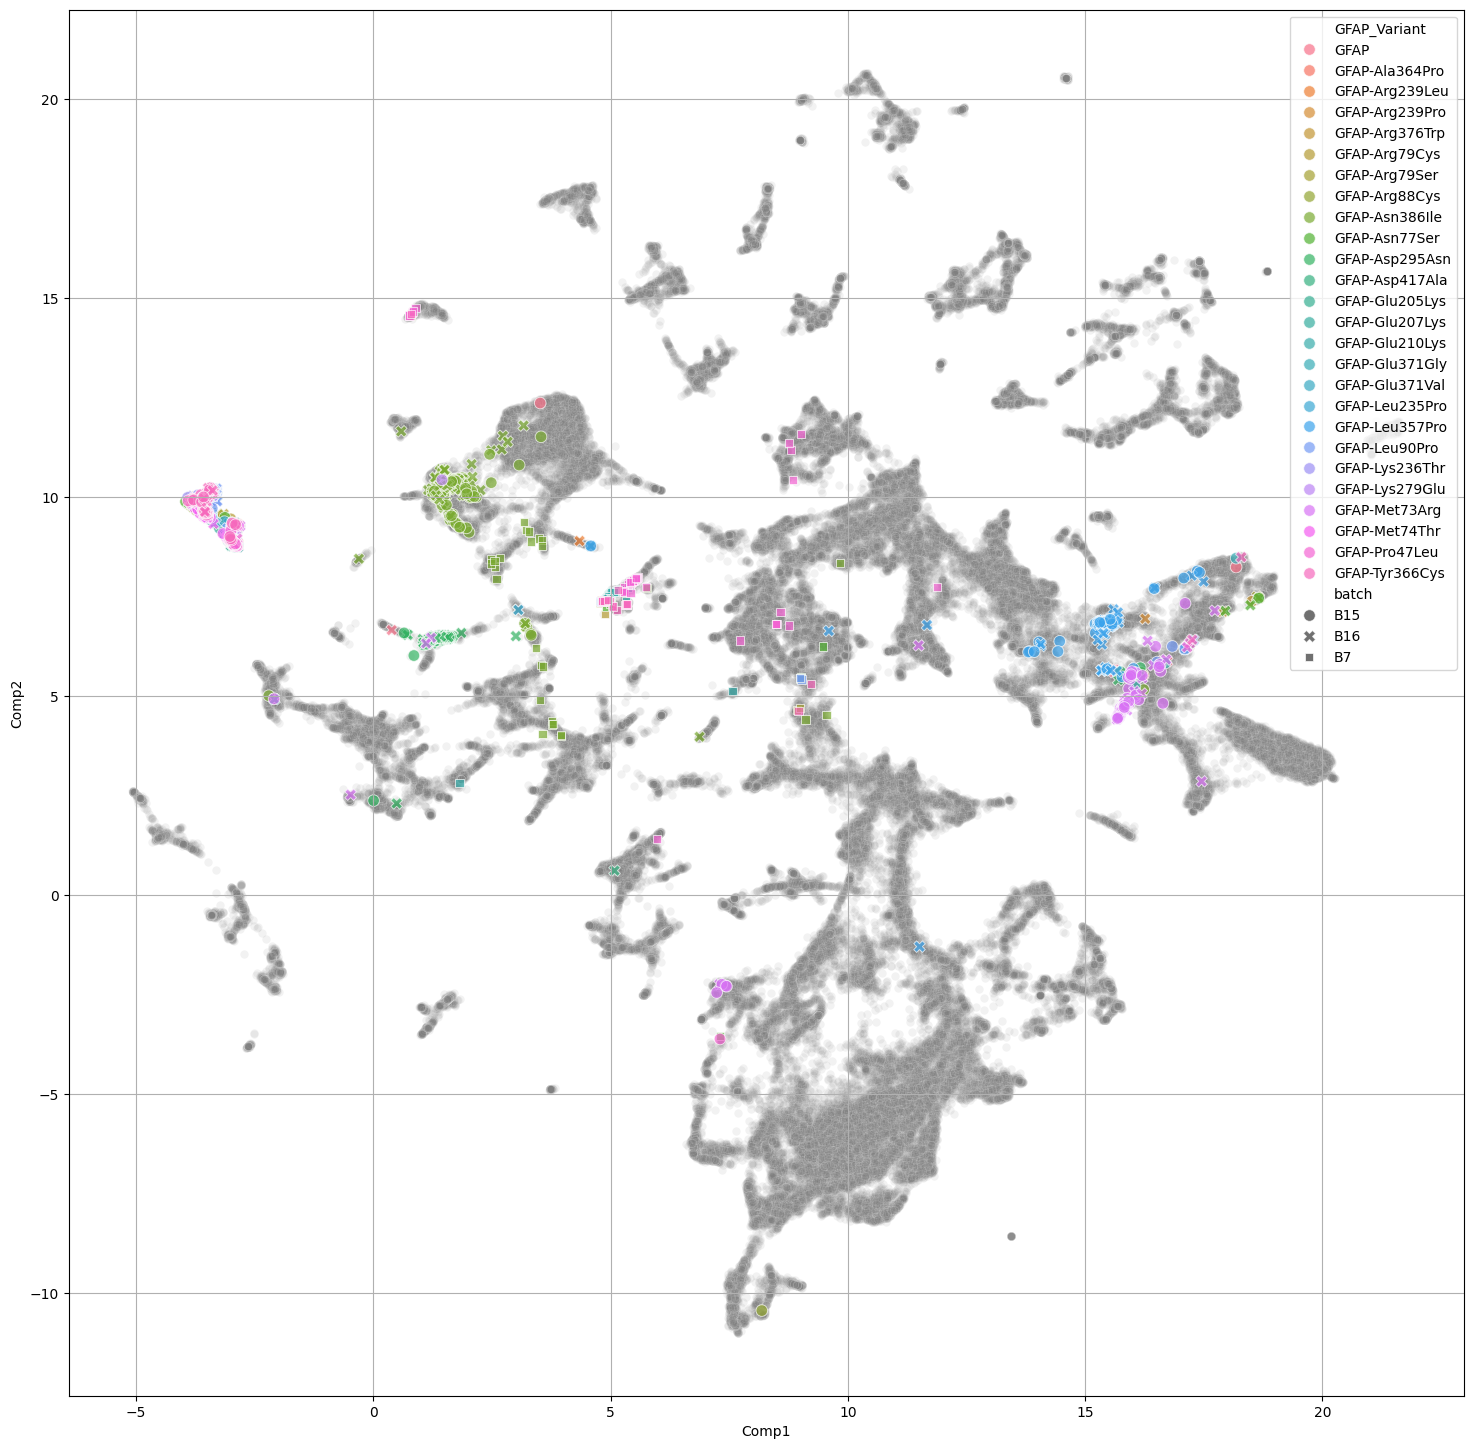

In [32]:
plot_gene_umap(umap_test_df, "GFAP")

/tmp/ipykernel_948654/2881440059.py:13: UserWarning: The palette list has more values (38) than needed (37), which may not be intended.
  sns.scatterplot(umap_df.filter(pl.col(f"{gene}_Variant") != "000"), x="Comp1", y="Comp2", hue=f"{gene}_Variant", style="batch", palette=colors, ax=ax, s=70, alpha=0.7)


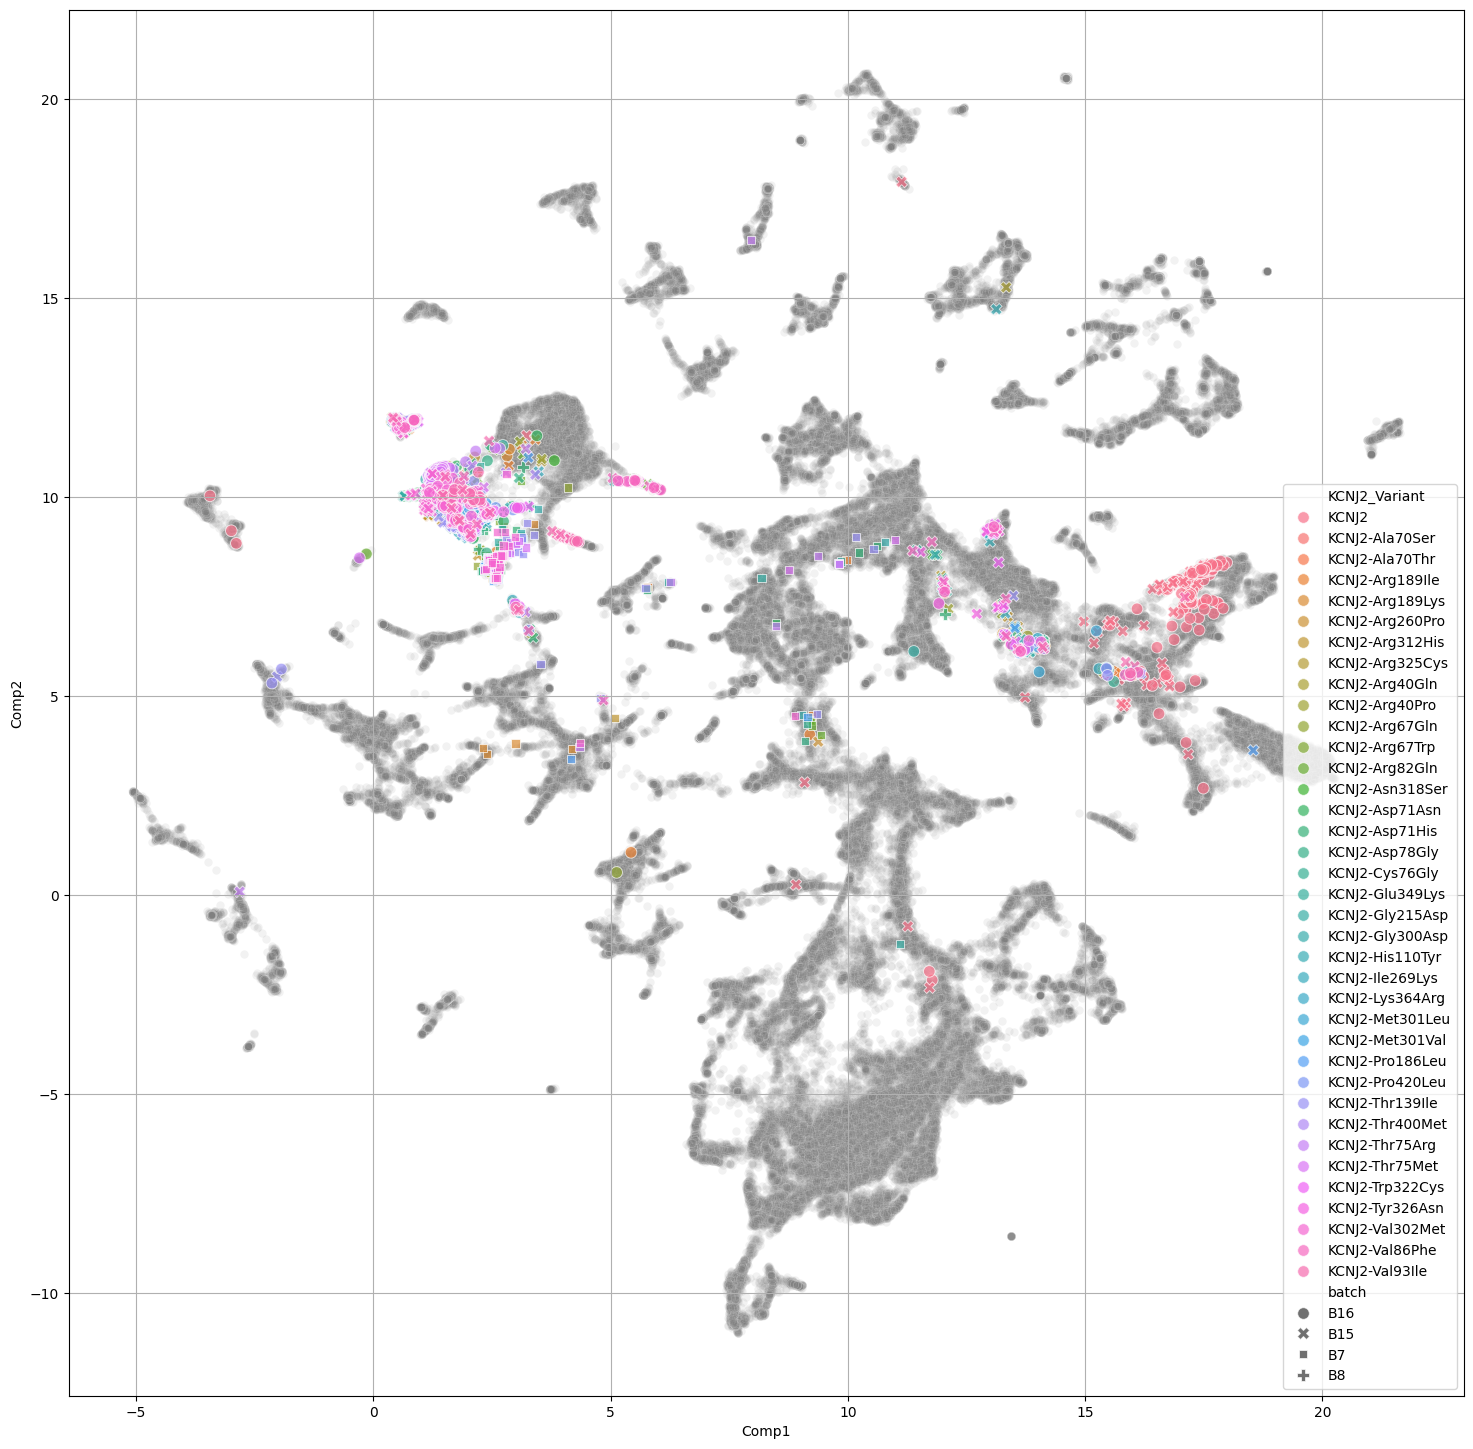

In [37]:
plot_gene_umap(umap_test_df, "KCNJ2")

In [6]:
prot_count = umap_test_df.group_by("Metadata_Protein").agg(pl.count().alias("Frequency"))
prot_count

/tmp/ipykernel_960360/1007082342.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  prot_count = umap_test_df.group_by("Metadata_Protein").agg(pl.count().alias("Frequency"))


Metadata_Protein,Frequency
str,u32
"""GCK-Gly44Asp""",39
"""KRAS-Gly12Asp""",139
"""KRT6A-Ser176Pro""",26
"""F9-Asn166Tyr""",80
"""SMAD3-Arg279Lys""",520
…,…
"""SMN2-Gly287Arg""",29
"""PHYH-Gly204Ser""",246
"""CCM2-Ala205Ser""",112


Cool, illustrative examples:
- NCAT2: no significant mislocalization, we see spread of variants across large area. There is the interesting "island" - I wonder what these cells look like. Should extend my cell search and plot function for this group. 
- RP2: clear mislocalization of one variant. It obviously separates from the rest.
- MYOZ2: 3 variants, >80% all piled on top of eachother on one very small dot.
- LDHB: 1 variant clearly different


Next steps:
- Reproduce their cluster analysis with GO:CC and Corum complexes. Try implement the idea that I had for spatial enrichment. 
- Adapt pooled-rare plotting functions for the Varchamp data so that I can look up specific cells based on the UMAP location.
- Make comparable UMAPs with CellProfiler features: use all same QA/QC filters, plus downsample to ~10%